In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from utils.utils import *
from CrabNet_eg.kingcrab import CrabNet
from CrabNet_eg.model import Model
from CrabNet_eg.get_compute_device import get_compute_device

from sklearn.metrics import mean_absolute_error as mae, \
                            r2_score as r2, \
                            mean_squared_error as mse

compute_device = get_compute_device()

In [ ]:
from pymatgen.core import Composition

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['Times New Roman'],
    "font.size": 24,
    'axes.unicode_minus': False 
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300 

In [3]:
# https://www.snumat.com/¶
hse_data = pd.read_csv('./data/hse_data.csv', index_col=0)
hse_data

,Material,Chemical_formula,Band_gap_HSE,Direct_or_indirect_HSE,Band_gap_GGA,Space_group_cif,Free_energy
0,Ge1Se8V4,Ge(V4Se8),0.000000,Indirect,0.000000,44.0,-5.897176
1,Cu2Ge1Se3,Cu2(GeSe3),0.357144,Indirect,0.057361,9.0,-3.574910
2,Cl4Co1Na2,Na2(CoCl4),4.477341,Direct,2.780673,62.0,-3.567538
3,Cr1Na1Se2,NaCrSe2,1.138949,Indirect,0.407413,166.0,-4.752246
4,Al2Fe3Si4,AlFe1.50Si2,0.000000,Indirect,0.000000,63.0,-6.420703
...,...,...,...,...,...,...,...
13714,Ga2In6O8Pt1,(PtIn6)(GaO4)2,1.503397,Indirect,0.613842,225.0,-5.429347
13715,Ge1In7Ir1O8,IrIn7GeO8,1.276845,Indirect,0.422346,216.0,-5.519259
13716,Ge1Mn1O4Zn1,ZnMn(GeO4),2.672193,Indirect,1.597849,62.0,-6.256881
13717,Ge2Mn1O7Sr2,Sr2Mn(Ge2O7),3.170080,Direct,2.025250,113.0,-6.705552


In [4]:
hse_data = hse_data[['Material','Band_gap_HSE','Band_gap_GGA','Space_group_cif','Free_energy']]
hse_data.columns = ['formula', 'HSE', 'GGA', 'spacegroup','free_energy']
hse_data['index'] = hse_data.index
hse_data

,formula,HSE,GGA,spacegroup,free_energy,index
0,Ge1Se8V4,0.000000,0.000000,44.0,-5.897176,0
1,Cu2Ge1Se3,0.357144,0.057361,9.0,-3.574910,1
2,Cl4Co1Na2,4.477341,2.780673,62.0,-3.567538,2
3,Cr1Na1Se2,1.138949,0.407413,166.0,-4.752246,3
4,Al2Fe3Si4,0.000000,0.000000,63.0,-6.420703,4
...,...,...,...,...,...,...
13714,Ga2In6O8Pt1,1.503397,0.613842,225.0,-5.429347,13714
13715,Ge1In7Ir1O8,1.276845,0.422346,216.0,-5.519259,13715
13716,Ge1Mn1O4Zn1,2.672193,1.597849,62.0,-6.256881,13716
13717,Ge2Mn1O7Sr2,3.170080,2.025250,113.0,-6.705552,13717


In [5]:
mp_data = pd.read_csv("./data/mp_data_new.csv")
mp_data = mp_data.rename(columns={'formula_pretty':'formula','symmetry':'spacegroup','band_gap':'GGA'})
mp_data = mp_data[['formula','spacegroup','GGA','formation_energy_per_atom','energy_above_hull']]
mp_data = mp_data.dropna(subset=['formula','spacegroup'])
mp_data['index'] = mp_data.index

In [6]:
# Convert to the same chemical formula format
hse_data['formula'] = hse_data['formula'].map(lambda x:Composition(x).reduced_formula)
mp_data['formula'] = mp_data['formula'].map(lambda x:Composition(x).reduced_formula)

In [7]:
#pick out some data https://docs.materialsproject.org/methodology/materials-methodology/electronic-structure/
mp_data['composition'] = mp_data['formula'].map(Composition)
mp_data['is_GGA_U'] = mp_data['composition'].map(lambda x : 1 if ('Co' in x and 'O' in x) or ('Co' in x and 'F' in x)
                                                 or ('Cr'in x and 'O' in x) or ('Cr' in x and 'F' in x)
                                                 or ('Fe'in x and 'O' in x) or ('Fe' in x and 'F' in x)
                                                 or ('Mn'in x and 'O' in x and x.reduced_formula != 'Mn2O3') or ('Mn' in x and 'F' in x)
                                                 or ('Mo'in x and 'O' in x) or ('Mo' in x and 'F' in x)
                                                 or ('Ni'in x and 'O' in x) or ('Ni' in x and 'F' in x)
                                                 or ('V'in x and 'O' in x and x.reduced_formula != 'VO') or ('V' in x and 'F' in x)
                                                 or ('W'in x and 'O' in x) or ('W' in x and 'F' in x)
                                                 else 0
                                                )
mp_data['is_GGA_U'].value_counts()

0    111772
1     42938
Name: is_GGA_U, dtype: int64

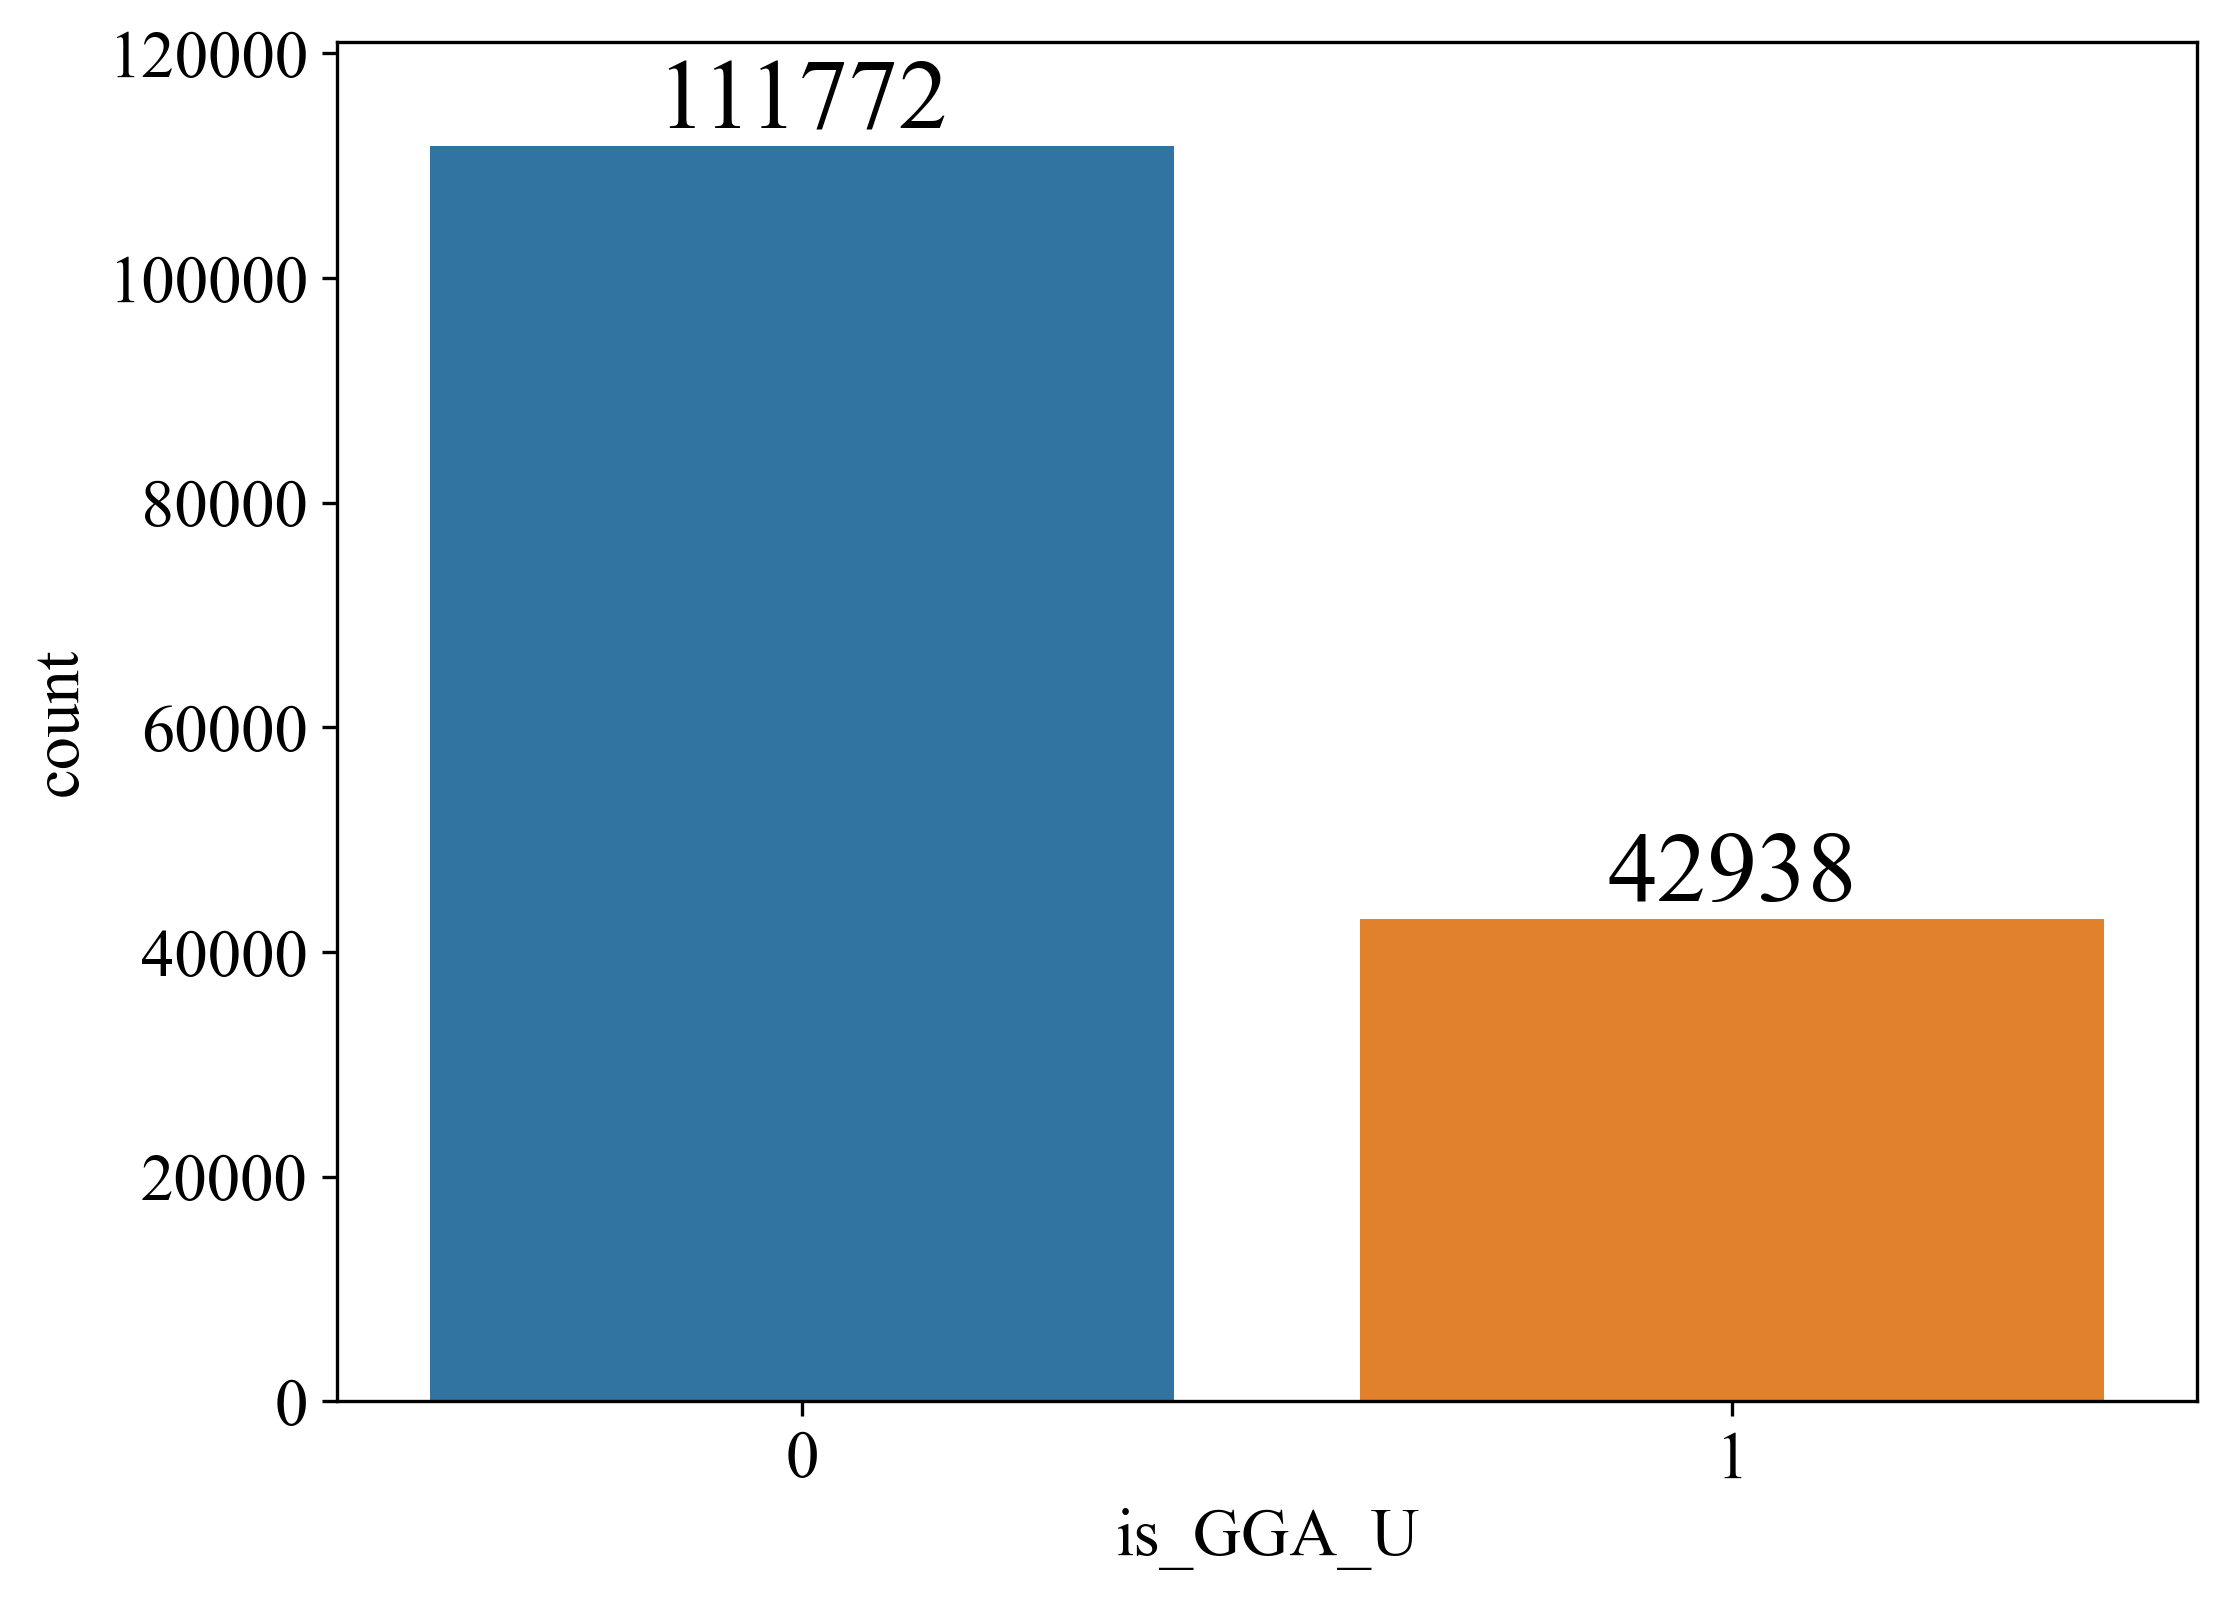

In [ ]:

ax = sns.countplot(x='is_GGA_U', data=mp_data)


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.ylim(0,121000)
plt.xlabel("is_GGA_U")

plt.show()

In [9]:
mp_data_U = mp_data[mp_data['is_GGA_U']==1]
mp_data_non_U = mp_data[mp_data['is_GGA_U']==0]

In [10]:
# take the intersection
inner_val = pd.merge(hse_data,mp_data_non_U, on=['formula','spacegroup'], how='inner')
inner_val

,formula,HSE,GGA_x,spacegroup,free_energy,index_x,GGA_y,formation_energy_per_atom,energy_above_hull,index_y,composition,is_GGA_U
0,Cu2GeSe3,0.357144,0.057361,9.0,-3.574910,1,0.0000,-0.477014,0.004076,145372,"(Cu, Ge, Se)",0
1,Na2CoCl4,4.477341,2.780673,62.0,-3.567538,2,0.0192,-1.650927,0.000000,101775,"(Na, Co, Cl)",0
2,NaCrSe2,1.138949,0.407413,166.0,-4.752246,3,0.7808,-1.044310,0.000000,66797,"(Na, Cr, Se)",0
3,Al2Fe3Si4,0.000000,0.000000,63.0,-6.420703,4,0.0000,-0.398392,0.010081,135101,"(Al, Fe, Si)",0
4,LaNi4B,0.000000,0.000000,191.0,-6.000872,5,0.0000,-0.416482,0.000000,124028,"(La, Ni, B)",0
...,...,...,...,...,...,...,...,...,...,...,...,...
14488,LaCuTeO,2.246626,1.417926,129.0,-5.791982,13707,1.1839,-2.177789,0.008628,82118,"(La, Cu, Te, O)",0
14489,La3CuS3O2,1.871609,1.088934,62.0,-6.802721,13708,0.9670,-2.742169,0.000000,84371,"(La, Cu, S, O)",0
14490,La3GaS5O,1.968560,1.153778,62.0,-6.389724,13713,1.2434,-2.395346,0.000000,9806,"(La, Ga, S, O)",0
14491,In6Ga2PtO8,1.503397,0.613842,225.0,-5.429347,13714,0.5672,-1.778338,0.000000,147393,"(In, Ga, Pt, O)",0


In [11]:
index_x = inner_val['index_x'].drop_duplicates(keep='first')
index_y = inner_val['index_y'].drop_duplicates(keep='first')
hse_data = hse_data.drop(index=index_x)
mp_data_non_U = mp_data_non_U.drop(index=index_y)

In [12]:
# Keep the closest result calculated by GGA
inner_val['GGA_err'] = np.abs(inner_val['GGA_x'] -  inner_val['GGA_y'])
inner_val = inner_val.groupby(['formula','spacegroup'],as_index=False).min(['GGA_err'])
keeped_data = inner_val
inner_val

,formula,spacegroup,HSE,GGA_x,free_energy,index_x,GGA_y,formation_energy_per_atom,energy_above_hull,index_y,is_GGA_U,GGA_err
0,Ag,194.0,0.000000,0.00000,-2.721318,4692,0.0000,0.007226,0.007226,50329,0,0.00000
1,Ag(AuF4)2,14.0,2.060208,0.29665,-3.233511,2126,0.2585,-1.385379,0.000000,108053,0,0.03815
2,Ag(Bi2S3)3,12.0,0.000000,0.00000,-4.253158,990,0.0000,-0.592917,0.029380,139192,0,0.00000
3,Ag(CO)2,15.0,2.428665,1.20222,-6.585129,11992,0.7248,-0.646890,0.415317,131239,0,0.47742
4,Ag(Mo3Se4)2,148.0,0.000000,0.00000,-6.886230,1822,0.0000,-0.714146,0.076030,24038,0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
10741,ZrVGe,139.0,0.000000,0.00000,-7.972034,12427,0.0000,-0.662724,0.000000,58116,0,0.00000
10742,ZrW2,227.0,0.000000,0.00000,-11.656033,10452,0.0000,-0.145862,0.000000,92326,0,0.00000
10743,ZrZn,221.0,0.000000,0.00000,-5.101354,11178,0.0000,-0.287190,0.000000,89431,0,0.00000
10744,ZrZn2,227.0,0.000000,0.00000,-3.880027,5652,0.0000,-0.302553,0.000000,96356,0,0.00000


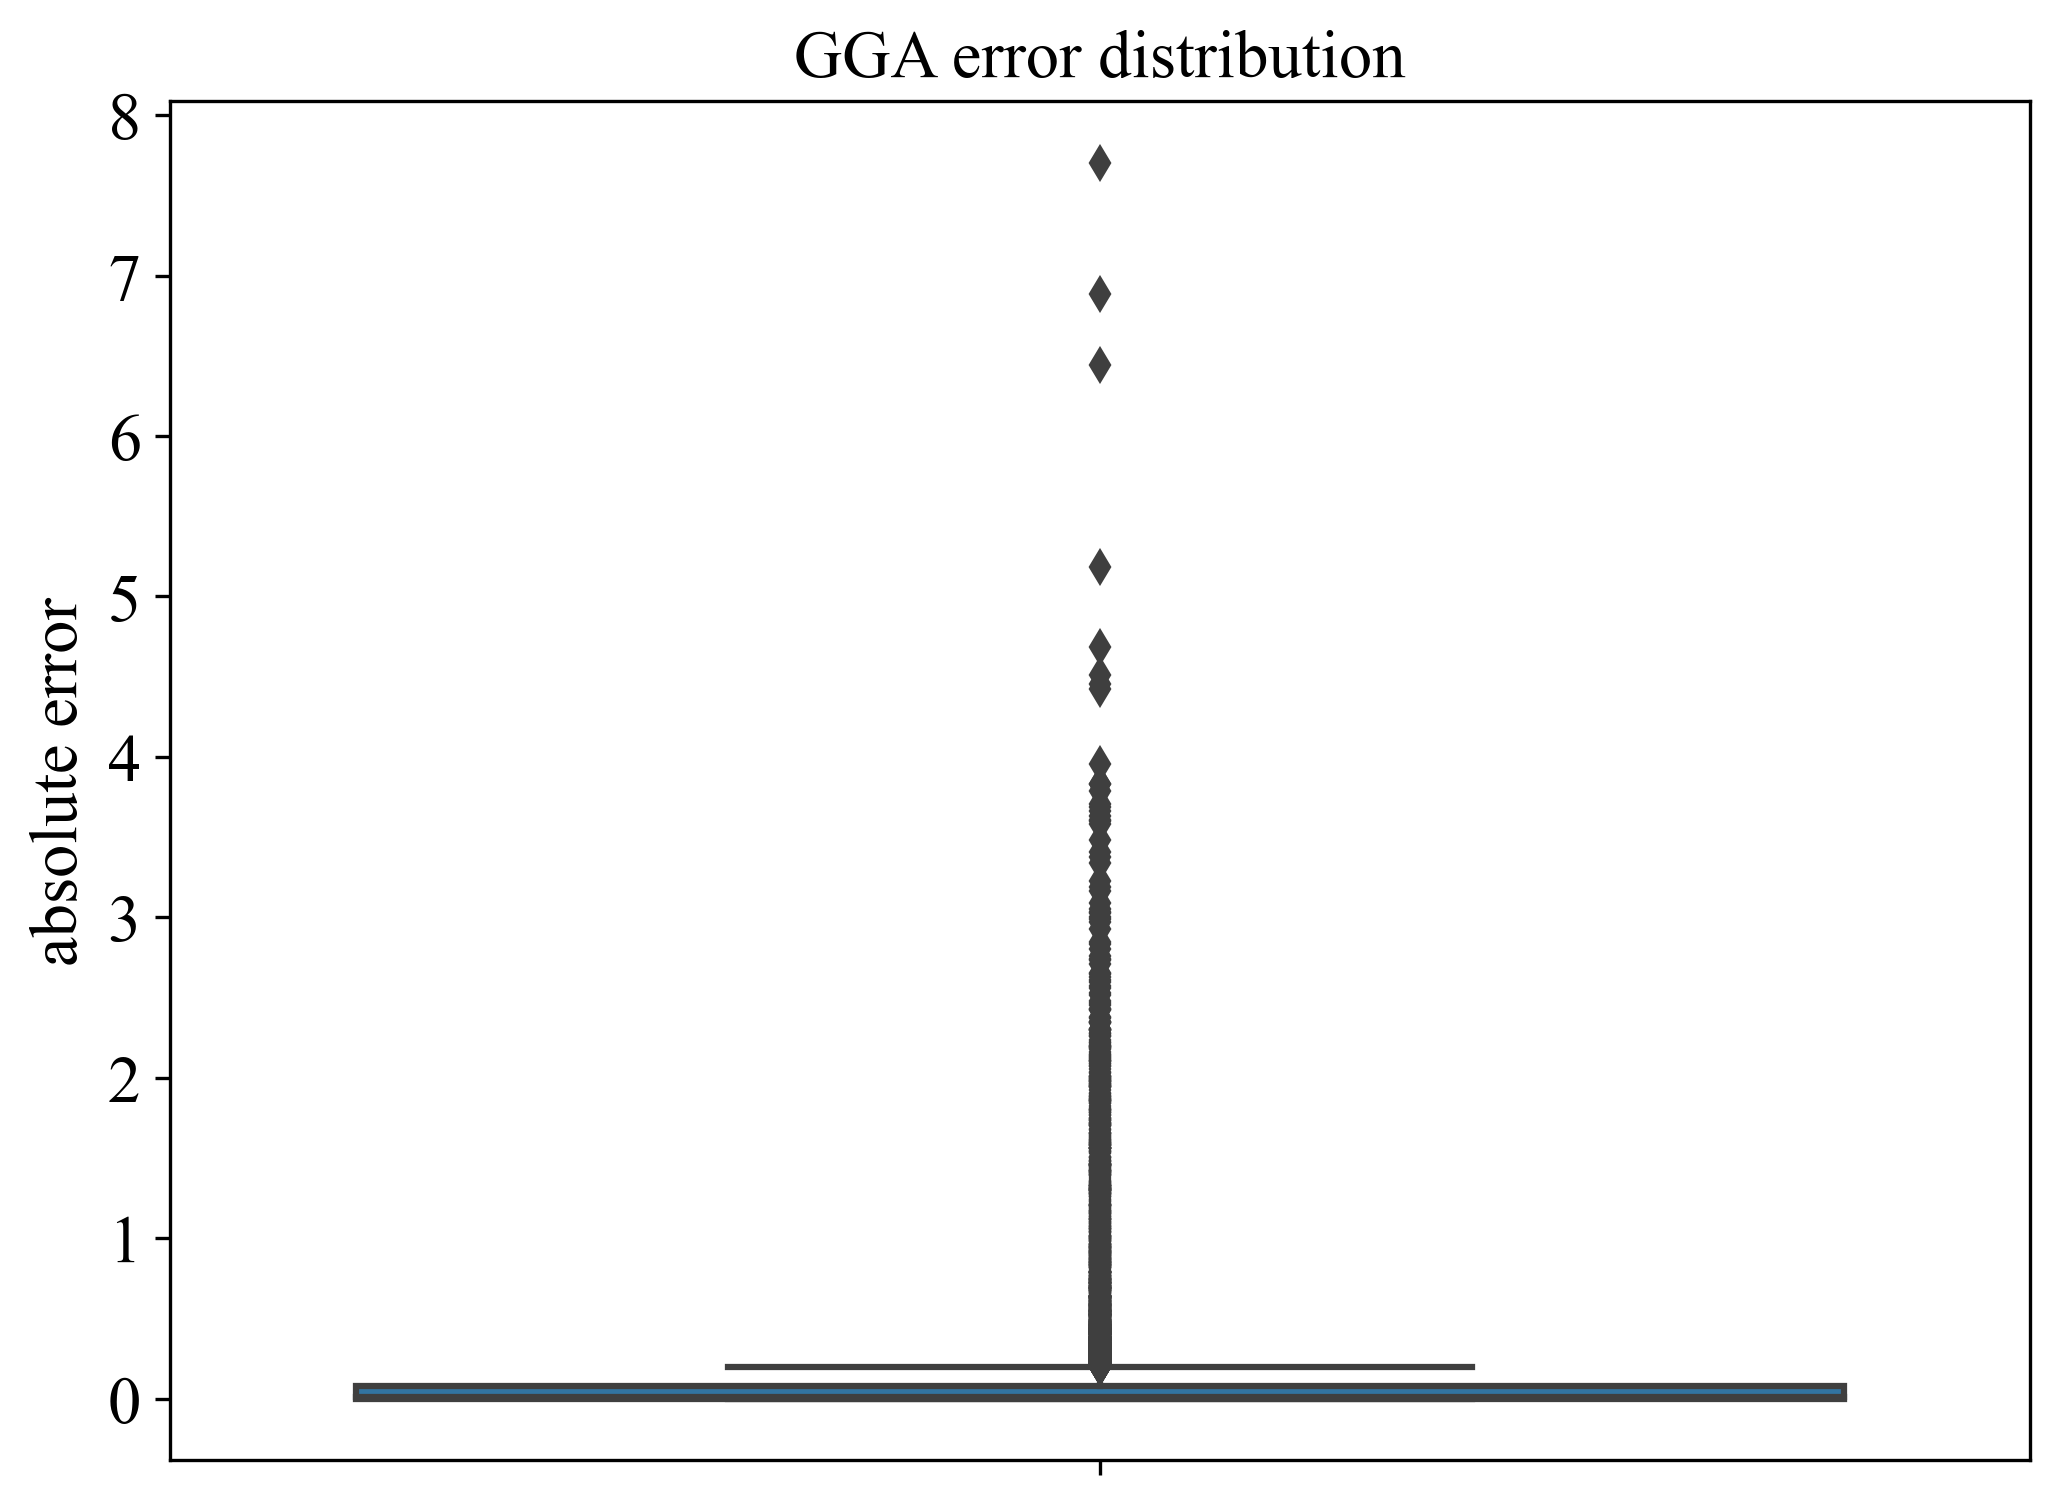

In [13]:
sns.boxplot(y=inner_val['GGA_err'])
plt.ylabel('absolute error')
plt.title('GGA error distribution')
plt.show()

Text(0.5, 1.0, 'GGA error distribution')

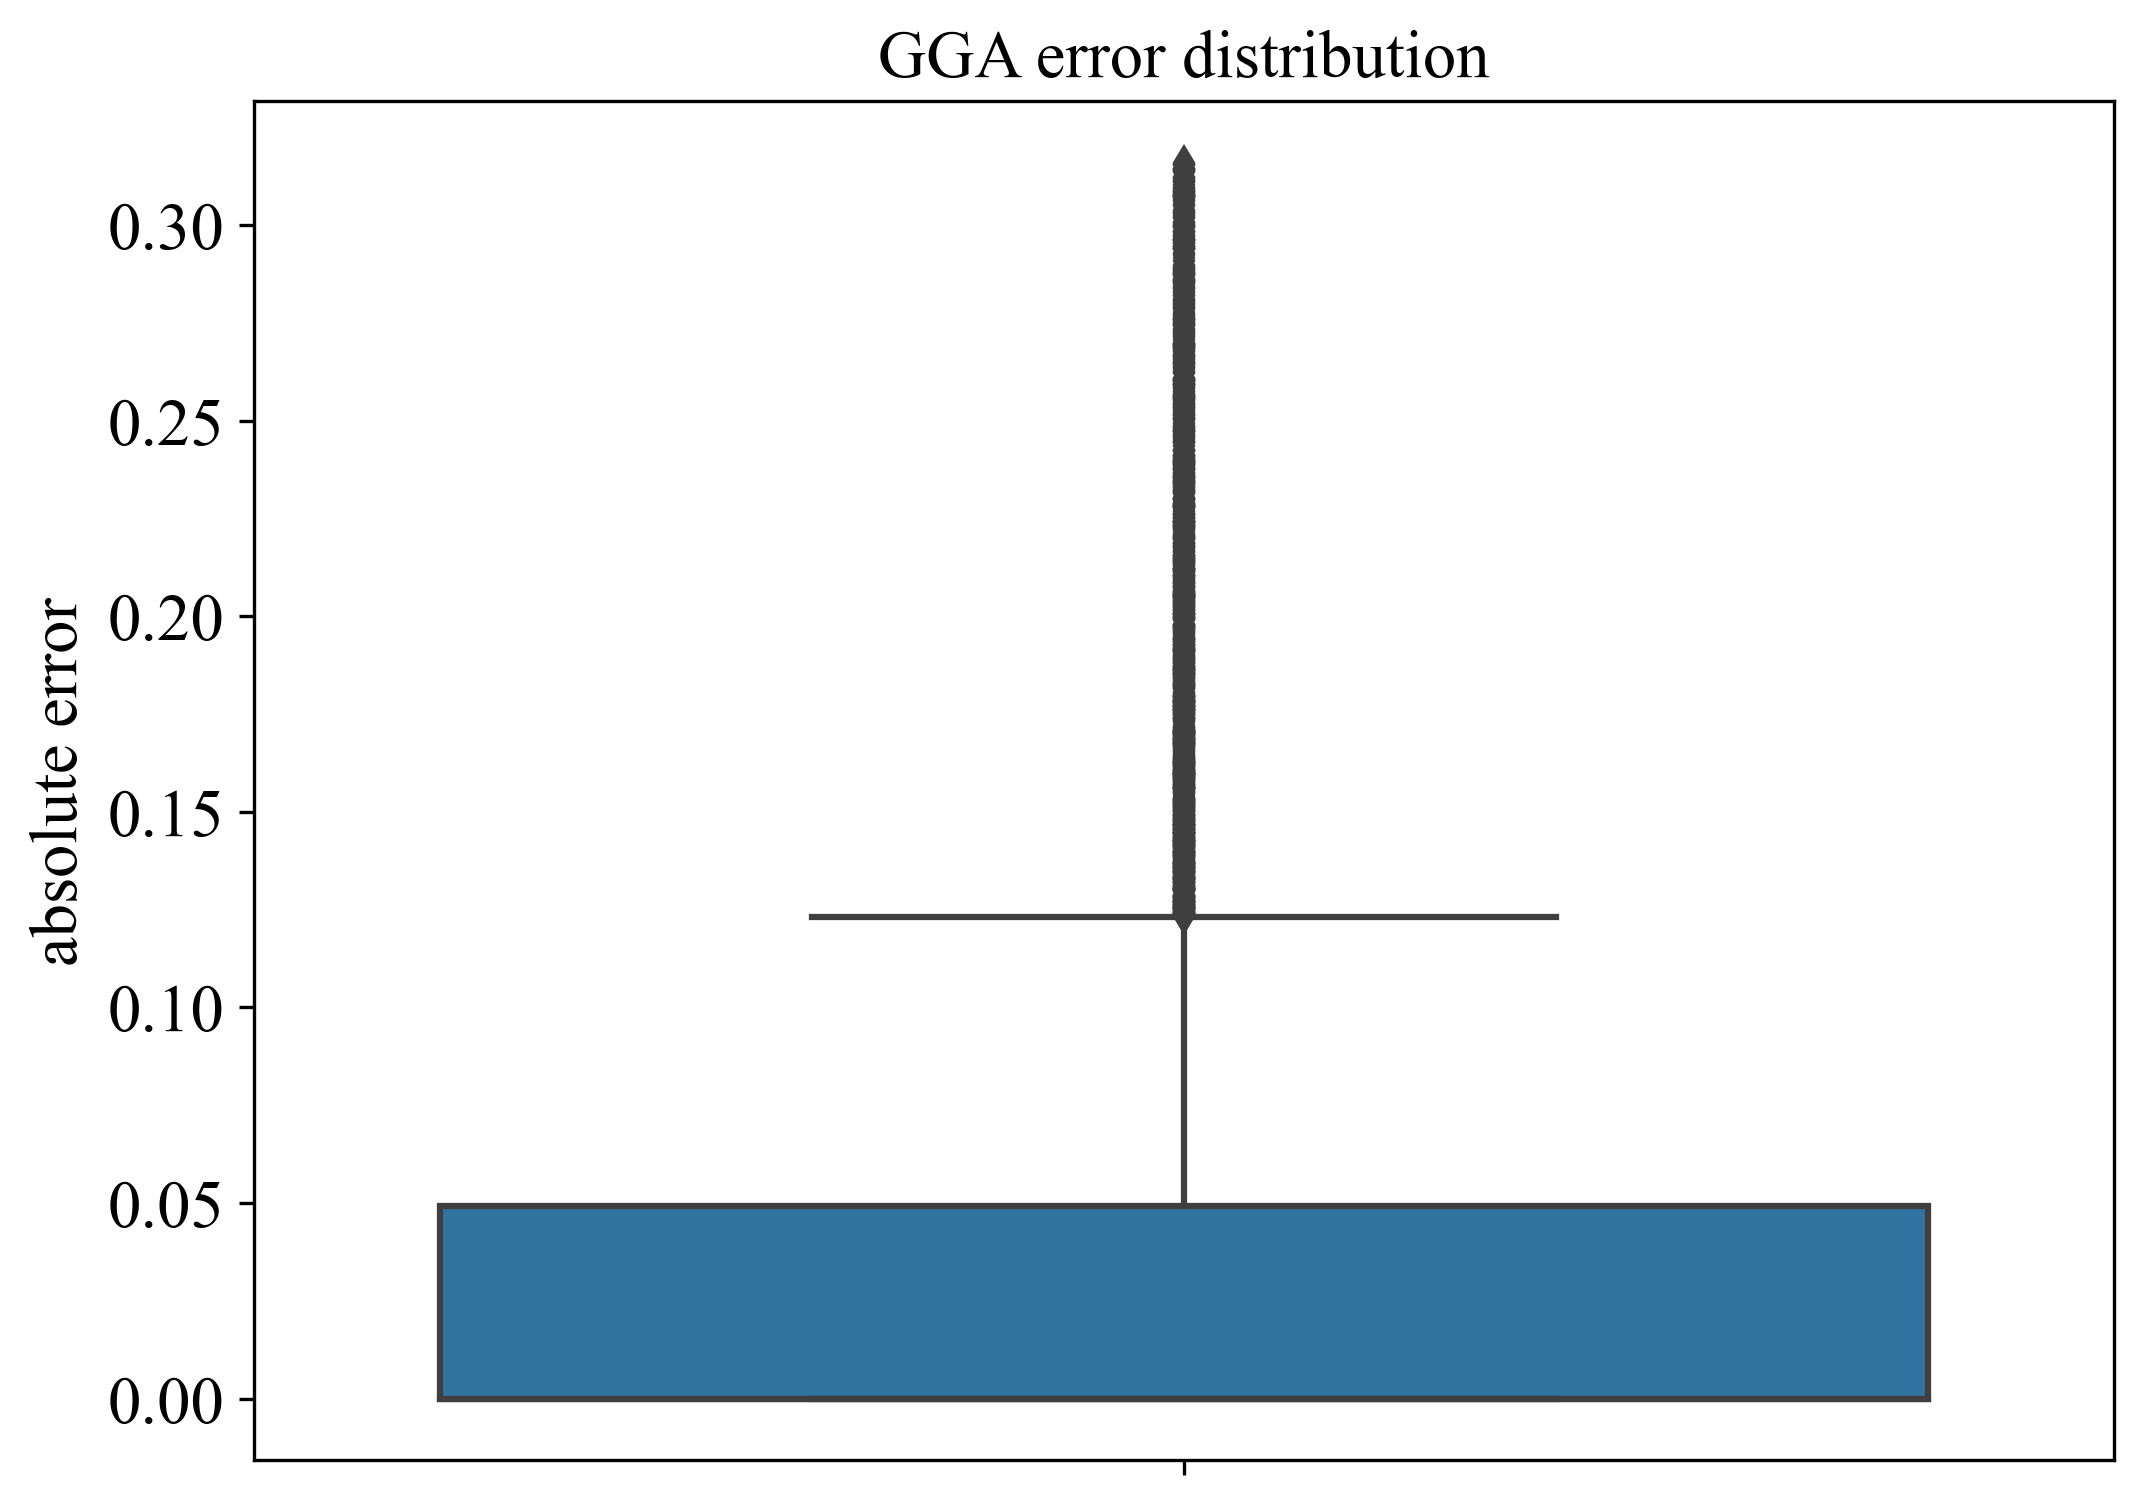

In [14]:
first_quartile = inner_val['GGA_err'].describe()['25%']
third_quartile = inner_val['GGA_err'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

inner_val = inner_val[(inner_val['GGA_err'] > (first_quartile - 3 * iqr)) &
            (inner_val['GGA_err'] < (third_quartile + 3 * iqr))]
sns.boxplot(y=inner_val['GGA_err'].dropna())
plt.ylabel('absolute error')
plt.title('GGA error distribution')

In [15]:
inner_val['GGA_err'].describe()

count    9753.000000
mean        0.038153
std         0.065453
min         0.000000
25%         0.000000
50%         0.000000
75%         0.049314
max         0.315769
Name: GGA_err, dtype: float64

In [16]:
def remove_single_element(df):
    # delete a single element
    df['composition'] = df['formula'].map(Composition)
    df['is_single_element'] = df['composition'].map(lambda x: 1 if len(x)==1 else 0)
    df = df[df['is_single_element']==0]
    df = df.drop(columns = 'is_single_element')
    return df
hse_data = remove_single_element(hse_data)
mp_data_U = remove_single_element(mp_data_U)
mp_data_non_U = remove_single_element(mp_data_non_U)
inner_val = remove_single_element(inner_val)
print(hse_data.shape,mp_data_U.shape,mp_data_non_U.shape,inner_val.shape)

(2294, 7) (42938, 8) (99222, 8) (9659, 13)


In [17]:
# data for ml
data = inner_val[['formula','spacegroup','HSE','GGA_y']]
data = data.rename(columns={'GGA_y':'band gap','HSE':'target'})
data['is_metal'] = data['target'].map(lambda x: 1 if x==0 else 0)
data

,formula,spacegroup,target,band gap,is_metal
1,Ag(AuF4)2,14.0,2.060208,0.2585,0
2,Ag(Bi2S3)3,12.0,0.000000,0.0000,1
4,Ag(Mo3Se4)2,148.0,0.000000,0.0000,1
5,Ag(MoSe)3,176.0,0.000000,0.0000,1
6,Ag(TeMo)6,12.0,0.000000,0.0000,1
...,...,...,...,...,...
10741,ZrVGe,139.0,0.000000,0.0000,1
10742,ZrW2,227.0,0.000000,0.0000,1
10743,ZrZn,221.0,0.000000,0.0000,1
10744,ZrZn2,227.0,0.000000,0.0000,1


In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data,shuffle=True,test_size=0.1,random_state=42)
test

,formula,spacegroup,target,band gap,is_metal
3942,I2(OF2)3,14.0,3.950436,2.1591,0
9720,TlSbO3,148.0,3.375061,2.4362,0
3518,GeO2,60.0,3.033993,1.5228,0
4340,K2ZrO3,62.0,5.029359,3.6617,0
4142,IrC4,68.0,0.000000,0.0000,1
...,...,...,...,...,...
2200,Ce(CoSi)2,139.0,0.000000,0.0000,1
1402,BiSe,164.0,0.000000,0.0000,1
9143,Te7Pd20,148.0,0.000000,0.0000,1
9485,TiSe,62.0,0.000000,0.0000,1


In [19]:
data = data.drop(index=test.index).reset_index(drop=True)
data

,formula,spacegroup,target,band gap,is_metal
0,Ag(Bi2S3)3,12.0,0.000000,0.0000,1
1,Ag(Mo3Se4)2,148.0,0.000000,0.0000,1
2,Ag(TeMo)6,12.0,0.000000,0.0000,1
3,Ag13OsO6,226.0,0.000000,0.0000,1
4,Ag2AsS2,7.0,1.314572,0.5615,0
...,...,...,...,...,...
8688,ZrVGe,139.0,0.000000,0.0000,1
8689,ZrW2,227.0,0.000000,0.0000,1
8690,ZrZn,221.0,0.000000,0.0000,1
8691,ZrZn2,227.0,0.000000,0.0000,1


Generating EDM: 100%|██████████| 966/966 [00:00<00:00, 234513.96formulae/s]


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11992839 parameters

loading data with up to 6 elements in the formula
MAE: 0.1357631809074252
R2: 0.9696462032124821
RMSE: 0.39542882173318955



Generating EDM: 100%|██████████| 966/966 [00:00<00:00, 236858.28formulae/s]


loading data with up to 6 elements in the formula
MAE: 0.1292219529676615
R2: 0.9731204938709629
RMSE: 0.37211095165893626
loading data with up to 6 elements in the formula
MAE: 0.13451387125147155
R2: 0.973350389610407
RMSE: 0.37051623438684445
loading data with up to 6 elements in the formula


Generating EDM: 100%|██████████| 966/966 [00:00<00:00, 236388.43formulae/s]


MAE: 0.13003598786757253
R2: 0.972885340865187
RMSE: 0.37373509725932297
loading data with up to 6 elements in the formula
MAE: 0.1348813985321645
R2: 0.9733414460180112
RMSE: 0.3705784016784451
0.1292219529676615 1


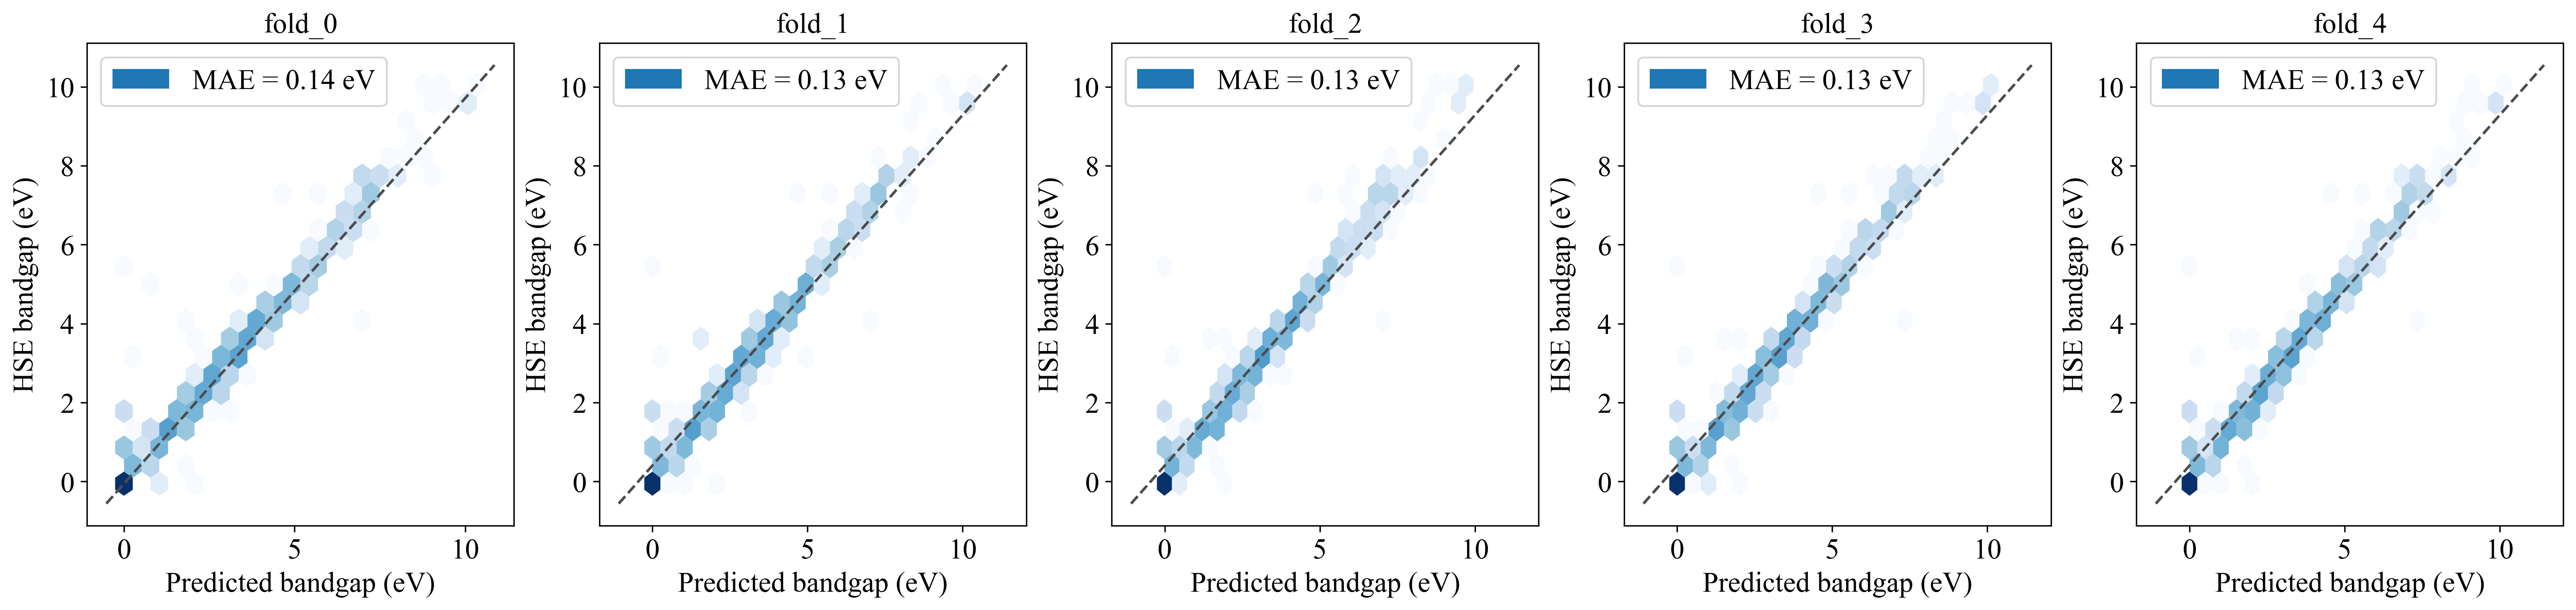

In [ ]:
model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                      model_name='', verbose=True, classification=False)
best_mae = 1
best_fold = 0
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i in range(0,5):
    model.load_network(f'./models/trained_models/fold_{i}.pth')
    real = test['target']
    model.load_data(test)
    pred  = model.predict(model.data_loader)[1]
    pred = np.nan_to_num(pred, copy=True, nan=0.0)
    hexbin = axs[i].hexbin(pred, real, gridsize=20, cmap='Blues', mincnt=1, bins='log', edgecolor='none',label='MAE = %.2f eV'%mae(real, pred))
    axs[i].set_xlabel('Predicted bandgap (eV)')
    axs[i].set_ylabel('HSE bandgap (eV)')
    axs[i].set_title('fold_'+str(i))
    axs[i].legend()

    axs[i].plot(axs[0].get_xlim(), axs[i].get_ylim(), ls="--", c=".3")
    print(f"MAE: {mae(real, pred)}")
    print(f"R2: {r2(real, pred)}")
    print(f"RMSE: {np.sqrt(mse(real, pred))}")
    tmp_mae = mae(real, pred)
    if tmp_mae < best_mae:
        best_mae = tmp_mae
        best_fold = i
print(best_mae,best_fold)
plt.show()

In [24]:
modifier = Modifier()
mp_data_non_U['GGA'] = mp_data_non_U['GGA'].map(lambda x: 0 if x <=0.01 else x)
hse = modifier.modify(mp_data_non_U['formula'].values,mp_data_non_U['GGA'].values)
hse


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11992839 parameters



Generating EDM: 100%|██████████| 99222/99222 [00:00<00:00, 146960.32formulae/s]


loading data with up to 8 elements in the formula


,formula,band gap,hse,count
0,Mg149Tc,0.0978,0.576305,2
1,K2CuF4,0.0000,0.000000,3
2,Ba6Y2Ga4O15,3.6041,5.098232,4
3,CsRb2TlF6,3.6496,5.319313,4
4,YCrB4,0.1589,0.945993,3
...,...,...,...,...
99217,ScPaOs2,0.0000,0.000000,3
99218,CeSe2,1.0291,1.676570,2
99219,WN2,0.1365,0.793655,2
99220,Al(CuO2)2,0.0000,0.000000,3


In [37]:
mp_data_non_U = mp_data_non_U.reset_index(drop=True).iloc[:,:-2]
mp_data_non_U

,formula,spacegroup,GGA,formation_energy_per_atom,energy_above_hull,index,composition,is_GGA_U
0,Mg149Tc,187,0.0978,-0.018674,0.000000,2,"(Mg, Tc)",0
1,K2CuF4,142,0.0000,-2.546095,0.000000,4,"(K, Cu, F)",0
2,Ba6Y2Ga4O15,13,3.6041,-2.990437,0.000000,6,"(Ba, Y, Ga, O)",0
3,CsRb2TlF6,225,3.6496,-2.631976,0.055559,7,"(Cs, Rb, Tl, F)",0
4,YCrB4,55,0.1589,-0.653251,0.000000,9,"(Y, Cr, B)",0
...,...,...,...,...,...,...,...,...
99217,ScPaOs2,225,0.0000,-0.342177,0.000000,154708,"(Sc, Pa, Os)",0
99218,CeSe2,10,1.0291,-1.395955,0.521610,154709,"(Ce, Se)",0
99219,WN2,61,0.1365,-0.390109,0.149157,154710,"(W, N)",0
99220,Al(CuO2)2,88,0.0000,-1.619474,0.203042,154711,"(Al, Cu, O)",0


In [38]:
mp_data_U =  mp_data_U.reset_index(drop=True)
mp_data_U['target'] = mp_data_U['GGA']
mp_data_non_U['target'] = hse['hse']
mp_data_hse = pd.concat([mp_data_non_U,mp_data_U],axis=0).reset_index(drop=True)
mp_data_hse

,formula,spacegroup,GGA,formation_energy_per_atom,energy_above_hull,index,composition,is_GGA_U,target,gap
0,Mg149Tc,187,0.0978,-0.018674,0.000000,2,"(Mg, Tc)",0,0.576305,NaN
1,K2CuF4,142,0.0000,-2.546095,0.000000,4,"(K, Cu, F)",0,0.000000,NaN
2,Ba6Y2Ga4O15,13,3.6041,-2.990437,0.000000,6,"(Ba, Y, Ga, O)",0,5.098232,NaN
3,CsRb2TlF6,225,3.6496,-2.631976,0.055559,7,"(Cs, Rb, Tl, F)",0,5.319313,NaN
4,YCrB4,55,0.1589,-0.653251,0.000000,9,"(Y, Cr, B)",0,0.945993,NaN
...,...,...,...,...,...,...,...,...,...,...
142155,CoH8(SO6)2,14,0.0222,-1.369593,0.074707,154693,"(Co, H, S, O)",1,0.022200,0.0222
142156,SrCaTiMnO5,1,0.8358,-3.095869,0.052808,154695,"(Sr, Ca, Ti, Mn, O)",1,0.835800,0.8358
142157,VPPbO7,14,0.0000,-1.926787,0.215726,154701,"(V, P, Pb, O)",1,0.000000,0.0000
142158,BaSmFeSnO6,216,2.1069,-2.532841,0.163558,154702,"(Ba, Sm, Fe, Sn, O)",1,2.106900,2.1069


In [39]:
mp_data_hse.reset_index(drop=True).to_csv('./data/mp_hse.csv')